In [2]:
def ista_solve_hot( A, d, la_array ):
    # ista_solve_hot: Iterative soft-thresholding for multiple values of
    # lambda with hot start for each case - the converged value for the previous
    # value of lambda is used as an initial condition for the current lambda.
    # this function solves the minimization problem
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

## 1a)

In [4]:
import numpy as np
from scipy.io import loadmat

In [10]:
#open BreastCancer.mat
BreastCancer = loadmat("BreastCancer.mat")
print(BreastCancer.keys())
X = BreastCancer['X']
y = BreastCancer['y']

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


((295, 8141), (295, 1))

In [16]:
# use the first 100 rows from X
patient_100 = X[:100]
decease_100 = y[:100]

# Appropriate values of λ may range from 10−6 to 20, spaced logarithmically
la_array_100 = np.logspace(-6, np.log10(20), 20)


In [20]:
W = ista_solve_hot(patient_100, decease_100, la_array_100)
print(W)
print(W.shape)

[[ 0.00598828  0.00599754  0.00600665 ...  0.          0.
  -0.        ]
 [-0.01282642 -0.01285551 -0.01288415 ... -0.         -0.
  -0.        ]
 [-0.00190487 -0.00190954 -0.00191412 ... -0.         -0.
  -0.        ]
 ...
 [-0.00299179 -0.00299773 -0.00300361 ... -0.         -0.
  -0.        ]
 [-0.00995832 -0.00997278 -0.009987   ... -0.         -0.
  -0.        ]
 [-0.00111583 -0.00111445 -0.00111309 ... -0.         -0.
  -0.        ]]
(8141, 20)


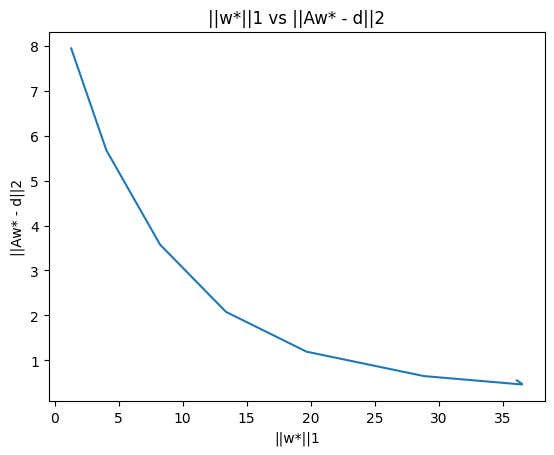

In [24]:
# create the curve by finding w∗ for different λ, and plotting ∥w∗∥1 vs. ∥Aw∗ − d∥2.
import matplotlib.pyplot as plt
norm1 = np.linalg.norm(W, 1, axis=0)
norm2 = np.zeros(len(la_array_100))
for i, each_lambda in enumerate(la_array_100):
    norm2[i] = np.linalg.norm(patient_100@W[:, i:i+1] - decease_100, 2)
plt.plot(norm1, norm2)
plt.xlabel('||w*||1')
plt.ylabel('||Aw* - d||2')
plt.title('||w*||1 vs ||Aw* - d||2')
plt.show()

## 1b)

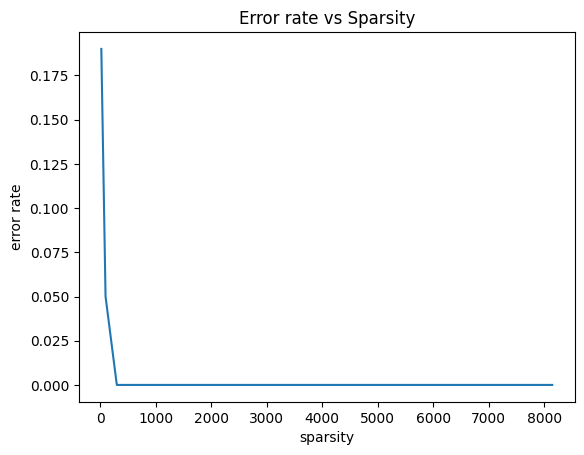

In [25]:
# the error rate as the number of incorrect predictions divided by the total number of predictions and the sparsity as the number of nonzero entries in w∗
# plot the error rate on the vertical-axis versus the sparsity on the horizontal-axis as λ varies
error_rate = np.zeros(len(la_array_100))
sparsity = np.zeros(len(la_array_100))
for i in range(len(la_array_100)):
    error_rate[i] = np.sum(np.sign(patient_100@W[:, i:i+1]) != decease_100) / len(decease_100)
    sparsity[i] = np.count_nonzero(W[:, i:i+1])
plt.plot(sparsity, error_rate)
plt.xlabel('sparsity')
plt.ylabel('error rate')
plt.title('Error rate vs Sparsity')
plt.show()


## 1c)

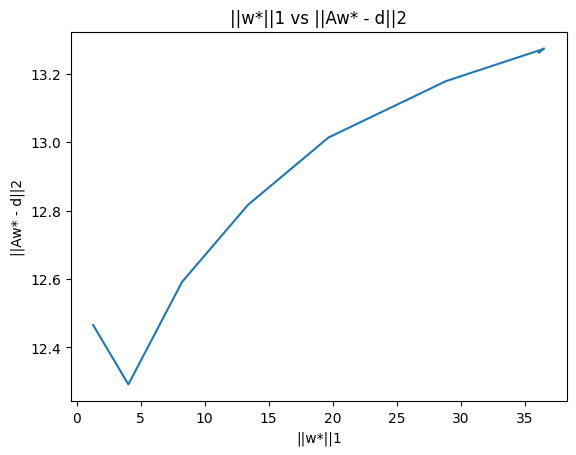

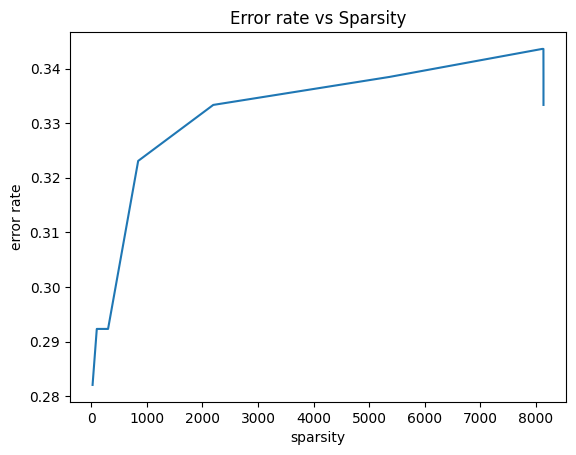

In [27]:
# using the W above, and using validation or test data, rows 101-295 of the data matrix to display the ||w*||1 vs ||Aw* - d||2 and Error rate vs Sparsity
patient_295 = X[100:]
decease_295 = y[100:]
norm1 = np.linalg.norm(W, 1, axis=0)
norm2 = np.zeros(len(la_array_100))
for i, each_lambda in enumerate(la_array_100):
    norm2[i] = np.linalg.norm(patient_295@W[:, i:i+1] - decease_295, 2)
plt.plot(norm1, norm2)
plt.xlabel('||w*||1')
plt.ylabel('||Aw* - d||2')
plt.title('||w*||1 vs ||Aw* - d||2')
plt.show()

error_rate = np.zeros(len(la_array_100))
sparsity = np.zeros(len(la_array_100))
for i in range(len(la_array_100)):
    error_rate[i] = np.sum(np.sign(patient_295@W[:, i:i+1]) != decease_295) / len(decease_295)
    sparsity[i] = np.count_nonzero(W[:, i:i+1])
plt.plot(sparsity, error_rate)
plt.xlabel('sparsity')
plt.ylabel('error rate')
plt.title('Error rate vs Sparsity')
plt.show()

## 2a)

In [36]:
# randomly shuffle the data into ten subsets of size 29-30
np.random.seed(0)  
shuffled_indices_x = np.random.permutation(X.shape[0])
X_shuffled = X[shuffled_indices_x] 

subset_sizes = [30]*5 + [29]*5 
# Create subsets
subsets_x = [X_shuffled[sum(subset_sizes[:i]):sum(subset_sizes[:i+1])] for i in range(len(subset_sizes))]
print(len(subsets))

10


In [32]:
np.random.seed(1)  
shuffled_indices_y = np.random.permutation(y.shape[0])
y_shuffled = y[shuffled_indices_y] 
# Create subsets
subsets_y = [y_shuffled[sum(subset_sizes[:i]):sum(subset_sizes[:i+1])] for i in range(len(subset_sizes))]
print(len(subsets_y))

10


In [33]:
# Use the data in eight of the subsets to find a solution to the Lasso optimization
def validation_test_lasso(i,j):
    x_validation = subsets_x[i]
    y_validation = subsets_y[i]
    x_test = subsets_x[j]
    y_test = subsets_y[j]
    x_train = np.concatenate(subsets_x[:i] + subsets_x[i+1:j] + subsets_x[j+1:])
    y_train = np.concatenate(subsets_y[:i] + subsets_y[i+1:j] + subsets_y[j+1:])
    W = ista_solve_hot(x_train, y_train, la_array_100)
    # Compute the prediction error using each w on x_validation
    # use the solution that has the smallest prediction error to find the best λ
    best_la = 0
    lowest_error_rate = 1000
    best_w = np.zeros((x_train.shape[1],1))
    for l in range(len(la_array_100)):
        error_rate = np.sum(np.sign(x_validation@W[:, l:l+1]) != y_validation) / len(y_validation)
        if error_rate < lowest_error_rate:
            lowest_error_rate = error_rate
            best_la = la_array_100[l]
            best_w = W[:, l:l+1]
    # Compute the test error on the final subset of the data for the choice of λ that minimizes the prediction error
    test_error_rate = np.sum(np.sign(x_test@best_w) != y_test) / len(y_test)
    # the squared error on the validation data for the best λ
    squared_error = np.linalg.norm(x_validation@best_w - y_validation, 2)
    return test_error_rate, squared_error

In [40]:
# Use the data in eight of the subsets to find a solution to the Lasso optimization
def validation_test_ridge(i,j):
    x_validation = subsets_x[i]
    y_validation = subsets_y[i]
    x_test = subsets_x[j]
    y_test = subsets_y[j]
    x_train = np.concatenate(subsets_x[:i] + subsets_x[i+1:j] + subsets_x[j+1:])
    y_train = np.concatenate(subsets_y[:i] + subsets_y[i+1:j] + subsets_y[j+1:])
    W = ridge_reg(x_train, y_train, la_array_100)
    # Compute the prediction error using each w on x_validation
    # use the solution that has the smallest prediction error to find the best λ
    best_la = 0
    lowest_error_rate = 1000
    best_w = np.zeros((x_train.shape[1],1))
    for l in range(len(la_array_100)):
        error_rate = np.sum(np.sign(x_validation@W[:, l:l+1]) != y_validation) / len(y_validation)
        if error_rate < lowest_error_rate:
            lowest_error_rate = error_rate
            best_la = la_array_100[l]
            best_w = W[:, l:l+1]
    # Compute the test error on the final subset of the data for the choice of λ that minimizes the prediction error
    test_error_rate = np.sum(np.sign(x_test@best_w) != y_test) / len(y_test)
    # the squared error on the validation data for the best λ
    squared_error = np.linalg.norm(x_validation@best_w - y_validation, 2)
    return test_error_rate, squared_error

In [37]:
total_error_rate = 0
total_squared_error = 0
for i in range(10):
    for j in range(10):
        if i != j:
            test_error_rate, squared_error = validation_test_lasso(i,j)
            total_error_rate += test_error_rate
            total_squared_error += squared_error
print(total_error_rate/90)
print(total_squared_error/90)

0.13257982120051084
2.916822723538982


In [50]:
total_error_rate = 0
total_squared_error = 0
for i in range(10):
    for j in range(10):
        if i != j:
            test_error_rate, squared_error = validation_test_ridge(i,j)
            total_error_rate += test_error_rate
            total_squared_error += squared_error
print(f'Average Error Rate_Ridge: ' + total_error_rate/90)
print(f'Average Error Rate_Ridge: ' + total_squared_error/90)

KeyboardInterrupt: 

In [49]:
def ridge_reg(A,d,la_array):
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    s = A.shape[0]
    f = A.shape[1]
    w = np.zeros((f,1))
    num_lam = len(la_array)
    X = np.zeros((f, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            w = A.T@np.linalg.inv(A@A.T + each_lambda*np.eye(s))@d
            X[:, i:i+1] = w
    return X